# Simple example for the Quintic

In [ ]:
# uncomment the following line to install the package if you haven't done so already
# %pip install git+https://github.com/ruehlef/cymetric.git

  Cloning https://github.com/ruehlef/cymetric.git to /private/var/folders/5n/0kqh94h112j137zhqw9phb480000gn/T/pip-req-build-_2l3mhaa
  Running command git clone --filter=blob:none --quiet https://github.com/ruehlef/cymetric.git /private/var/folders/5n/0kqh94h112j137zhqw9phb480000gn/T/pip-req-build-_2l3mhaa
  Resolved https://github.com/ruehlef/cymetric.git to commit 61eebf5322d9d229de537b1531458b3e8718b7bf
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'cymetric' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'cymetric'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for cymetric: filename=cymetric-0.4a0-py3-none-any.whl size=130483 sha256

In [1]:
import pickle
import os
import seaborn as sns
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# The package uses tensorflow by default. To work with torch, uncomment the next line. To work with tensorflow, comment it out.
os.environ['CYMETRIC_FRAMEWORK'] = 'torch'

### Generate some points

In [3]:
from cymetric.pointgen.pointgen_mathematica import PointGeneratorMathematica

kernel_path = "/Applications/Wolfram.app/Contents/MacOS/WolframKernel"
psi = -2.
monomials = np.array((5 * np.eye(5, dtype=np.int64)).tolist() + [[1,1,1,1,1]])
coefficients = np.array(np.ones(5).tolist() + [-5 * psi])
kmoduli = np.ones(1)
ambient = np.array([4])
n_fold = 3
num_pts = 50000

pg = PointGeneratorMathematica([monomials], [coefficients], kmoduli, ambient, kernel_path=kernel_path)
dirname = 'points_quintic_test'
if not os.path.exists(os.path.join(dirname, 'basis.pickle')):
    kappa = pg.prepare_dataset(num_pts, dirname)
    pg.prepare_basis(dirname, kappa)

# Torch Examples

In [4]:
import torch
import torch.nn as nn

from cymetric.models.models import PhiFSModel, MultFSModel, MatrixFSModel, FreeModel, AddFSModel
from cymetric.models.helper import train_model, prepare_basis
from cymetric.models.callbacks import RicciCallback, SigmaCallback, KaehlerCallback, TransitionCallback, VolkCallback

with open(os.path.join(dirname, 'basis.pickle'), 'rb') as f:
    BASIS = pickle.load(f)
BASIS = prepare_basis(BASIS)
data = np.load(os.path.join(dirname, 'dataset.npz'), allow_pickle=True)

### Demonstration of the PhiFSModel

In [5]:
# a simple NN for the metric
n_in = data['X_train'].shape[1]
n_out = 1
metric_nn = nn.Sequential(
    nn.Linear(n_in, 64),
    nn.GELU(),
    nn.Linear(64, 64),
    nn.GELU(),
    nn.Linear(64, 64),
    nn.GELU(),
    nn.Linear(64, n_out)
)
model = PhiFSModel(metric_nn, BASIS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Some extra information about the relative errors
scb = SigmaCallback((data['X_val'], data['y_val']))
kcb = KaehlerCallback((data['X_val'], data['y_val']))
val_pullbacks = model.pullbacks(torch.from_numpy(data['X_val']).type(torch.float32).to(model.device)).detach().numpy()
rcb = RicciCallback((data['X_val'], data['y_val']), val_pullbacks)
tcb = TransitionCallback((data['X_val'], data['y_val']))
vcb = VolkCallback((data['X_val'], data['y_val']))
cb_list = [scb, kcb, tcb, vcb, rcb]


Epoch 1/5


100%|██████████| 5/5 [00:16<00:00,  3.39s/it]



 - General loss phase: 0.173367
 - Volume loss phase:  0.446619
 - Sigma measure val:      0.1504
 - Sigma measure val:      0.1504
 - Kaehler measure val:    7.3280e-15
 - Kaehler measure val:    7.3280e-15
 - Transition measure val: 0.0019
 - Volume val:               5.2030
 - Transition measure val: 0.0019
 - Volume val:               5.2030
 - Ricci measure val:      1.3937
 - Ricci measure val:      1.3937

Epoch 2/5

Epoch 2/5


100%|██████████| 5/5 [00:23<00:00,  4.60s/it]



 - General loss phase: 0.135270
 - Volume loss phase:  0.294180
 - Sigma measure val:      0.2101
 - Sigma measure val:      0.2101
 - Kaehler measure val:    7.5613e-15
 - Kaehler measure val:    7.5613e-15
 - Transition measure val: 0.0012
 - Volume val:               5.7396
 - Transition measure val: 0.0012
 - Volume val:               5.7396
 - Ricci measure val:      1.0361
 - Ricci measure val:      1.0361

Epoch 3/5

Epoch 3/5


100%|██████████| 5/5 [00:25<00:00,  5.17s/it]



 - General loss phase: 0.130129
 - Volume loss phase:  0.206327
 - Sigma measure val:      0.1269
 - Sigma measure val:      0.1269
 - Kaehler measure val:    6.9391e-15
 - Kaehler measure val:    6.9391e-15
 - Transition measure val: 5.0040e-04
 - Volume val:               4.7542
 - Transition measure val: 5.0040e-04
 - Volume val:               4.7542
 - Ricci measure val:      0.8121
 - Ricci measure val:      0.8121

Epoch 4/5

Epoch 4/5


100%|██████████| 5/5 [00:23<00:00,  4.74s/it]



 - General loss phase: 0.127320
 - Volume loss phase:  0.242606
 - Sigma measure val:      0.1288
 - Sigma measure val:      0.1288
 - Kaehler measure val:    6.8495e-15
 - Kaehler measure val:    6.8495e-15
 - Transition measure val: 6.4098e-04
 - Volume val:               4.6791
 - Transition measure val: 6.4098e-04
 - Volume val:               4.6791
 - Ricci measure val:      0.6904
 - Ricci measure val:      0.6904

Epoch 5/5

Epoch 5/5


100%|██████████| 5/5 [00:23<00:00,  4.65s/it]



 - General loss phase: 0.125681
 - Volume loss phase:  0.204492
 - Sigma measure val:      0.1293
 - Sigma measure val:      0.1293
 - Kaehler measure val:    7.2162e-15
 - Kaehler measure val:    7.2162e-15
 - Transition measure val: 6.0480e-04
 - Volume val:               5.1110
 - Transition measure val: 6.0480e-04
 - Volume val:               5.1110
 - Ricci measure val:      0.7541
 - Ricci measure val:      0.7541


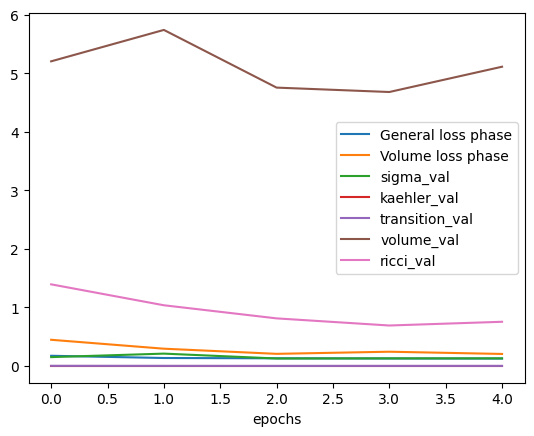

In [10]:
# train the model. You can skip using the callbacks (especially the Ricci callback) to save time
trained_model, history = train_model(
        model, data, optimizer=optimizer, epochs=5, callbacks=cb_list
    )

# Plot the results
for k, v in history.items():
    if k != 'epochs':
        sns.lineplot(history, x='epochs', y=v, label=k)

### Demonstration of the MultFSModel

In [7]:
# a simple NN for the metric
n_in = data['X_train'].shape[1]
n_out = BASIS['NFOLD']**2
metric_nn = nn.Sequential(
    nn.Linear(n_in, 64),
    nn.GELU(),
    nn.Linear(64, 64),
    nn.GELU(),
    nn.Linear(64, 64),
    nn.GELU(),
    nn.Linear(64, n_out)
)
model = MultFSModel(metric_nn, BASIS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scb = SigmaCallback((data['X_val'], data['y_val']))
kcb = KaehlerCallback((data['X_val'], data['y_val']))
val_pullbacks = model.pullbacks(torch.from_numpy(data['X_val']).type(torch.float32).to(model.device)).detach().numpy()
rcb = RicciCallback((data['X_val'], data['y_val']), val_pullbacks)
tcb = TransitionCallback((data['X_val'], data['y_val']))
vcb = VolkCallback((data['X_val'], data['y_val']))
cb_list = [scb, kcb, tcb, vcb, rcb]


Epoch 1/5


100%|██████████| 5/5 [00:01<00:00,  3.95it/s]



 - General loss phase: 0.177213
 - Volume loss phase:  0.267608
 - Sigma measure val:      0.1697
 - Kaehler measure val:    0.0054
 - Kaehler measure val:    0.0054
 - Transition measure val: 0.0073
 - Volume val:               5.3476
 - Transition measure val: 0.0073
 - Volume val:               5.3476
 - Ricci measure val:      2.0446

Epoch 2/5
 - Ricci measure val:      2.0446

Epoch 2/5


100%|██████████| 5/5 [00:01<00:00,  3.82it/s]



 - General loss phase: 0.136629
 - Volume loss phase:  0.237805
 - Sigma measure val:      0.1318
 - Kaehler measure val:    0.0048
 - Kaehler measure val:    0.0048
 - Transition measure val: 0.0048
 - Volume val:               4.9942
 - Transition measure val: 0.0048
 - Volume val:               4.9942
 - Ricci measure val:      1.6833

Epoch 3/5
 - Ricci measure val:      1.6833

Epoch 3/5


100%|██████████| 5/5 [00:01<00:00,  3.81it/s]



 - General loss phase: 0.126750
 - Volume loss phase:  0.218238
 - Sigma measure val:      0.1471
 - Kaehler measure val:    0.0054
 - Kaehler measure val:    0.0054
 - Transition measure val: 0.0032
 - Volume val:               5.2087
 - Transition measure val: 0.0032
 - Volume val:               5.2087
 - Ricci measure val:      1.3880

Epoch 4/5
 - Ricci measure val:      1.3880

Epoch 4/5


100%|██████████| 5/5 [00:01<00:00,  3.76it/s]



 - General loss phase: 0.121177
 - Volume loss phase:  0.193070
 - Sigma measure val:      0.1479
 - Kaehler measure val:    0.0057
 - Kaehler measure val:    0.0057
 - Transition measure val: 0.0024
 - Volume val:               5.2382
 - Transition measure val: 0.0024
 - Volume val:               5.2382
 - Ricci measure val:      1.1392

Epoch 5/5
 - Ricci measure val:      1.1392

Epoch 5/5


100%|██████████| 5/5 [00:01<00:00,  3.70it/s]



 - General loss phase: 0.118211
 - Volume loss phase:  0.258956
 - Sigma measure val:      0.1113
 - Kaehler measure val:    0.0067
 - Kaehler measure val:    0.0067
 - Transition measure val: 0.0023
 - Transition measure val: 0.0023
 - Volume val:               4.7837
 - Volume val:               4.7837
 - Ricci measure val:      1.0560
 - Ricci measure val:      1.0560


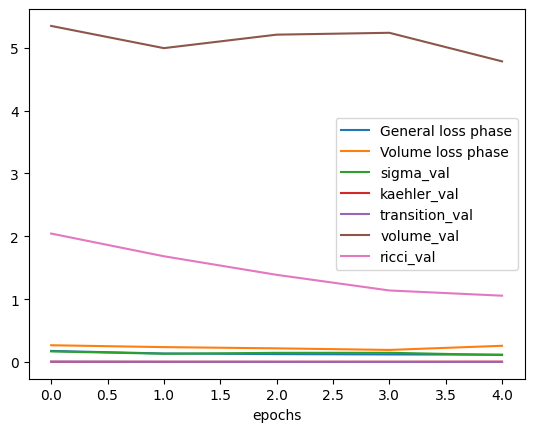

In [8]:
# train the model
trained_model, history = train_model(
        model, data, optimizer=optimizer, epochs=5, callbacks=cb_list
    )

# Plot the results
for k, v in history.items():
    if k != 'epochs':
        sns.lineplot(history, x='epochs', y=v, label=k)

# TensorFlow Examples

In [4]:
# If you ran the torch code above, comment out the line os.environ['CYMETRIC_FRAMEWORK'] = 'torch', 
# and restart your jupyter notebook kernel to clear the torch model from memory. 
# Also rerun the cell that generates (or reads in) the points, i.e., the "Generate some points" section

import tensorflow as tf
tfk = tf.keras

from cymetric.models.models import PhiFSModel, MultFSModel, MatrixFSModel, FreeModel, AddFSModel
from cymetric.models.helper import train_model, prepare_basis
from cymetric.models.callbacks import RicciCallback, SigmaCallback, KaehlerCallback, TransitionCallback, VolkCallback

with open(os.path.join(dirname, 'basis.pickle'), 'rb') as f:
    BASIS = pickle.load(f)
BASIS = prepare_basis(BASIS)
data = np.load(os.path.join(dirname, 'dataset.npz'), allow_pickle=True)


### Demonstration of the PhiFSModel

In [5]:
# a simple NN for the metric
nn_depth = 3
nn_width = 64
n_epochs = 50
n_in = data['X_train'].shape[1]
n_out = 1
metric_nn = tfk.Sequential()
metric_nn.add(tfk.Input(shape=(n_in,)))
for i in range(nn_depth):
    metric_nn.add(tfk.layers.Dense(nn_width, activation='gelu'))
metric_nn.add(tfk.layers.Dense(n_out, use_bias=False))

model = PhiFSModel(metric_nn, BASIS)
optimizer = tfk.optimizers.Adam(learning_rate=1e-3)

# Some extra information about the relative errors
scb = SigmaCallback((data['X_val'], data['y_val']))
kcb = KaehlerCallback((data['X_val'], data['y_val']))
val_pullbacks = model.pullbacks(tf.cast(data['X_val'], dtype=tf.float32))
rcb = RicciCallback((data['X_val'], data['y_val']), val_pullbacks)
tcb = TransitionCallback((data['X_val'], data['y_val']))
vcb = VolkCallback((data['X_val'], data['y_val']))
cb_list = [scb, kcb, tcb, vcb, rcb]


Epoch  1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1844 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1764 - transition_loss: 0.0080 - volk_loss: 0.0000e+00
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1844 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1764 - transition_loss: 0.0080 - volk_loss: 0.0000e+00
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1529 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1468 - transition_loss: 0.0061 - volk_loss: 0.0000e+00  - Sigma measure val:      0.1372
 - Sigma measure val:      0.1372


2025-07-17 18:19:20.192279: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 - Kaehler measure val:    5.5603e-15
 - Transition measure val: 0.0058
 - Volk val:               4.8333
 - Volk val:               4.8333
 - Ricci measure val:      1.5499
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - kaehler_loss: 0.0000e+00 - loss: 0.1530 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1469 - transition_loss: 0.0061 - volk_loss: 0.0000e+00 - sigma_val: 0.1372 - kaehler_val: 5.5603e-15 - transition_val: 0.0058 - volk_val: 4.8333 - ricci_val: 1.5499
 - Ricci measure val:      1.5499
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - kaehler_loss: 0.0000e+00 - loss: 0.1530 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1469 - transition_loss: 0.0061 - volk_loss: 0.0000e+00 - sigma_val: 0.1372 - kaehler_val: 5.5603e-15 - transition_val: 0.0058 - volk_val: 4.8333 - ricci_val: 1.5499

Epoch  2/5
  1/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1685 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1620 - transition_loss: 0.0064 - volk_loss: 0.0000e+00
Epoch  2/5
 63/704 ━━━━━━━━━━━━━

2025-07-17 18:19:23.498305: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1483 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1443 - transition_loss: 0.0040 - volk_loss: 0.0000e+00
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1483 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1443 - transition_loss: 0.0040 - volk_loss: 0.0000e+00
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1396 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1367 - transition_loss: 0.0028 - volk_loss: 0.0000e+00  - Sigma measure val:      0.1289
 - Sigma measure val:      0.1289
 - Kaehler measure val:    5.4706e-15
 - Transition measure val: 0.0029
 - Volk val:               4.9218
 - Kaehler measure val:    5.4706e-15
 - Transition measure val: 0.0029
 - Volk val:               4.9218
 - Ricci measure val:      1.4150
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1394 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1366 - transition_loss: 0.0029

2025-07-17 18:19:27.466245: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1391 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1365 - transition_loss: 0.0026 - volk_loss: 0.0000e+00
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1391 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1365 - transition_loss: 0.0026 - volk_loss: 0.0000e+00
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1337 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1313 - transition_loss: 0.0024 - volk_loss: 0.0000e+00 - Sigma measure val:      0.1233
 - Sigma measure val:      0.1233
 - Kaehler measure val:    5.7239e-15
 - Transition measure val: 0.0022
 - Volk val:               5.0842
 - Kaehler measure val:    5.7239e-15
 - Transition measure val: 0.0022
 - Volk val:               5.0842
 - Ricci measure val:      1.1660
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 490ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1343 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1319 - transition_loss: 0.0024

2025-07-17 18:19:35.371783: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1180 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1149 - transition_loss: 0.0031 - volk_loss: 0.0000e+00
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1180 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1149 - transition_loss: 0.0031 - volk_loss: 0.0000e+00
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1057 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1024 - transition_loss: 0.0033 - volk_loss: 0.0000e+00 - Sigma measure val:      0.1031
 - Sigma measure val:      0.1031
 - Kaehler measure val:    6.0325e-15
 - Transition measure val: 0.0032
 - Volk val:               4.9122
 - Kaehler measure val:    6.0325e-15
 - Transition measure val: 0.0032
 - Volk val:               4.9122
 - Ricci measure val:      0.7138
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - kaehler_loss: 0.0000e+00 - loss: 0.1054 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1021 - transition_loss: 0.0033

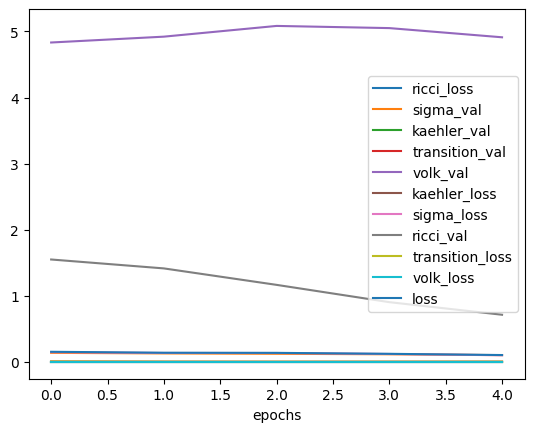

In [6]:
# train the model
trained_model, history = train_model(
        model, data, optimizer=optimizer, epochs=5, callbacks=cb_list
    )

# Plot the results
for k, v in history.items():
    if k != 'epochs':
        sns.lineplot(history, x='epochs', y=v, label=k)

### Demonstration of the MultFSModel

In [7]:
nn_depth = 3
nn_width = 64
n_epochs = 50
n_in = data['X_train'].shape[1]
n_out = BASIS['NFOLD']**2

# a simple NN for the metric
metric_nn = tfk.Sequential()
metric_nn.add(tfk.Input(shape=(n_in,)))
for i in range(nn_depth):
    metric_nn.add(tfk.layers.Dense(nn_width, activation='gelu'))
metric_nn.add(tfk.layers.Dense(n_out, use_bias=False))

model = MultFSModel(metric_nn, BASIS)
optimizer = tfk.optimizers.Adam(learning_rate=1e-3)

# Some extra information about the relative errors
scb = SigmaCallback((data['X_val'], data['y_val']))
kcb = KaehlerCallback((data['X_val'], data['y_val']))
val_pullbacks = model.pullbacks(tf.cast(data['X_val'], dtype=tf.float32))
rcb = RicciCallback((data['X_val'], data['y_val']), val_pullbacks)
tcb = TransitionCallback((data['X_val'], data['y_val']))
vcb = VolkCallback((data['X_val'], data['y_val']))
cb_list = [scb, kcb, tcb, vcb, rcb]


Epoch  1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - kaehler_loss: 0.0045 - loss: 0.1757 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1646 - transition_loss: 0.0067 - volk_loss: 0.0000e+00
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - kaehler_loss: 0.0045 - loss: 0.1757 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1646 - transition_loss: 0.0067 - volk_loss: 0.0000e+00
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - kaehler_loss: 0.0036 - loss: 0.1477 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1336 - transition_loss: 0.0104 - volk_loss: 0.0000e+00 - Sigma measure val:      0.1299
 - Sigma measure val:      0.1299
 - Kaehler measure val:    0.0039
 - Transition measure val: 0.0105
 - Kaehler measure val:    0.0039
 - Transition measure val: 0.0105
 - Volk val:               4.8060
 - Volk val:               4.8060
 - Ricci measure val:      1.8784
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 832ms/step - kaehler_loss: 0.0036 - loss: 0.1470 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1330 - transition_loss: 0.0104 - volk_loss

2025-07-17 18:21:17.077606: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - kaehler_loss: 0.0047 - loss: 0.1329 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1223 - transition_loss: 0.0059 - volk_loss: 0.0000e+00
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - kaehler_loss: 0.0047 - loss: 0.1329 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1223 - transition_loss: 0.0059 - volk_loss: 0.0000e+00
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - kaehler_loss: 0.0049 - loss: 0.1272 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1180 - transition_loss: 0.0043 - volk_loss: 0.0000e+00 - Sigma measure val:      0.1174
 - Kaehler measure val:    0.0049
 - Sigma measure val:      0.1174
 - Kaehler measure val:    0.0049
 - Transition measure val: 0.0043
 - Volk val:               4.7018
 - Transition measure val: 0.0043
 - Volk val:               4.7018
 - Ricci measure val:      1.4790
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - kaehler_loss: 0.0049 - loss: 0.1269 - ricci_loss: 0.0000e+00 - sigma_loss: 0.1177 - transition_loss: 0.0043 - volk_loss: 0.0000e+00

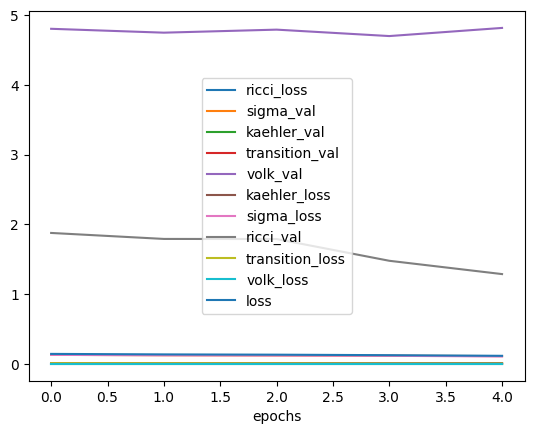

In [8]:
# train the model
trained_model, history = train_model(
        model, data, optimizer=optimizer, epochs=5, callbacks=cb_list
    )

# Plot the results
for k, v in history.items():
    if k != 'epochs':
        sns.lineplot(history, x='epochs', y=v, label=k)